# Prática 4: Pré-Processamento

### Kelvin Guilherme de Oliveira - 9293286
### Lucas Yudi Sugi - 9293251

Intro

## Dataset: Falhos de plantio



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#Leitura do dataset com o pandas
dataset = pd.read_csv('./datasets/agro/falhas_plantio_hashing.csv',sep=';',header=0,encoding='latin1',thousands=',')

#Extração dos atributos necessários
agro = dataset[['Perc_Falha','Perc_Infest_Inv','VM','Ph','FERT_L']].copy()

#Contando as linhas com Nan valores
counter = 0
for i in range(len(agro)):
    if(agro.iloc[i,:].isna().sum() != 0):
        counter += 1

print("Porcentagem de amostras com problema no dataset: ",counter/len(agro))

Porcentagem de amostras com problema no dataset:  0.4712789590606157


In [3]:
#Porcentagem de Nan por atributo
agro.isna().sum() / len(agro)

Perc_Falha         0.056173
Perc_Infest_Inv    0.000000
VM                 0.413996
Ph                 0.246271
FERT_L             0.002222
dtype: float64

Responder pergunta 1

Falar que além dos problemas de Nan valores também temos muitos zeros nas colunas Perc_Infest_Inv e FERT_L (que foram descobertos por causas das praticas anteriores). Devemos remover ambos para que o algoritmo de aprendizado de maquina possa alcancar uma maior acuracia

Responder pergunta 2

In [4]:
#Remoção dos Nan valores para a classe
agro = agro[~agro['Perc_Falha'].isna()]

#Porcentagem de Nan por atributo
agro.isna().sum() / len(agro)

Perc_Falha         0.000000
Perc_Infest_Inv    0.000000
VM                 0.401984
Ph                 0.252858
FERT_L             0.002354
dtype: float64

In [5]:
#Cálculo dos quantils para gerar as classes
classeA = agro['Perc_Falha'].quantile(q=0.20)
classeB = agro['Perc_Falha'].quantile(q=0.40)
classeC = agro['Perc_Falha'].quantile(q=0.60)
classeD = agro['Perc_Falha'].quantile(q=0.80)

#Converte os intervalos para uma classe
def convert(x):
    if(x < classeA):
        return 'A'
    elif((x > classeA) & (x < classeB)):
        return 'B'
    elif((x > classeB) & (x < classeC)):
        return 'C'
    elif((x > classeC) & (x < classeD)):
        return 'D'
    else:
        return 'E'
    
agro['Perc_Falha'] = agro['Perc_Falha'].apply(convert)

In [6]:
#Remoção dos 0 nas colunas (Tambem remove Nan)
agro = agro[(agro['Perc_Infest_Inv'] != 0) & (agro['FERT_L'] != 0)]

#Recalculando porcentagens de Nan por atributo
agro.isna().sum() / len(agro)

Perc_Falha         0.000000
Perc_Infest_Inv    0.000000
VM                 0.343164
Ph                 0.123324
FERT_L             0.000000
dtype: float64

In [7]:
#Limpeza 1 - Remove os NaN valores
agro1 = agro.dropna().copy()

#Mostando os dados
agro1.head()

,Perc_Falha,Perc_Infest_Inv,VM,Ph,FERT_L
2438,A,0.1226,6.57,4.5,1.15
2439,A,0.0664,6.47,4.5,1.15
2440,B,0.1133,6.14,4.5,1.15
2441,A,0.0136,6.94,4.7,1.15
2442,A,0.0551,6.62,5.9,1.15


In [8]:
#Imprimindo as medias de cada atributo
print("Média de VM: ",agro['VM'].mean())
print("Média de Ph: ",agro['Ph'].mean())

#Imprimindo as medianas de cada atributo
print("Mediana de VM:",agro['VM'].median())
print("Mediana de Ph:",agro['Ph'].median())

Média de VM:  6.2717755102040815
Média de Ph:  4.856666666666655
Mediana de VM: 6.28
Mediana de Ph: 4.75


In [9]:
#Transformação - Substituir os NaN valores pela mediana nos atributos VM e Ph e Perc_Falha
agro2 = agro.copy()

median = agro2['VM'].median()
agro2['VM'] = agro2['VM'].fillna(median)

median = agro2['Ph'].median()
agro2['Ph'] = agro2['Ph'].fillna(median)

#Mostando os dados
agro2.head()

,Perc_Falha,Perc_Infest_Inv,VM,Ph,FERT_L
2438,A,0.1226,6.57,4.5,1.15
2439,A,0.0664,6.47,4.5,1.15
2440,B,0.1133,6.14,4.5,1.15
2441,A,0.0136,6.94,4.7,1.15
2442,A,0.0551,6.62,5.9,1.15


In [10]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std


def reg_clas(data, columns, target, regression=False):
    """
    Executa classificação ou regressão do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    regression: Boleano. True para realizar uma regressão e False para classificação
    ---------------------------------------------------------------
    Realiza a classificação/regressão em 4 modelos (SVM com kernel linear, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, e knn com k=5)
    Plot o gráfico de desempenho para cada classificador/regressor.
    Retorna um dicionário com os classificadores/regressores treinados e as medidas de desempenho
    """
    
    # inicializa os modelos com os parâmetros solicitados
    if regression:
        svm_l = SVR(C=10*len(data), kernel='linear', cache_size=500, max_iter=1e6)
        svm_n = SVR(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
        dt = DecisionTreeRegressor(criterion='mse', splitter='best', min_samples_split=int(len(data)*0.05))
        knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='kd_tree')
    else:
        svm_l = SVC(C=10*len(data), kernel='linear', cache_size=500, max_iter=1e6)
        svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
        dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
        knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree')
    
    clfs = [svm_l, svm_n, dt, knn]
    clfs_names = ['svm_linear', 'svm_poly', 'dt', 'knn']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=5, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'svm_linear':[], 'svm_poly':[], 'dt':[], 'knn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # realiza predição no conjunto de teste e salva o resultado
            if regression:
                results[c_name].append( mean_squared_error(clf.predict(x_test), y_test) )
            else:
                results[c_name].append( clf.score(x_test, y_test) )
    
    # faz o plot de desempenho dos classificadores/regressores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos regressores - erro quadrático médio' if regression else \
            'Desempenho dos classificadores - acurácia'
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}

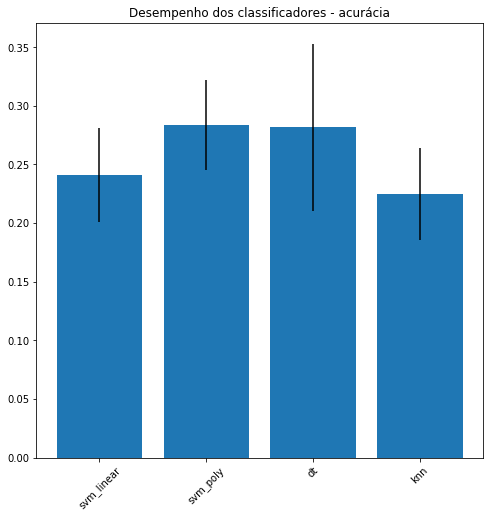

{'clfs': [SVC(C=4900, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  SVC(C=4900, cache_size=500, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=49,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best'),
  KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
      

In [11]:
#Normalizando os dados
agro1.iloc[:,1:5] = (agro1.iloc[:,1:5]-agro1.iloc[:,1:5].min())/(agro1.iloc[:,1:5].max()-agro1.iloc[:,1:5].min())

#Classificação
data = agro1
columns = [1,2,3,4]
target = 0

reg_clas(data, columns, target, regression=False)

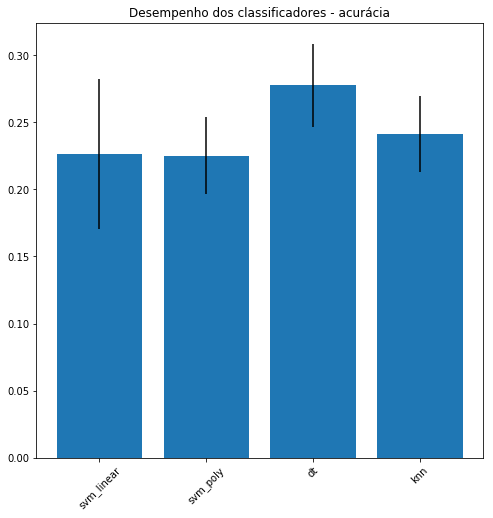

{'clfs': [SVC(C=7460, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  SVC(C=7460, cache_size=500, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=74,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best'),
  KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
      

In [12]:
#Normalizando os dados
agro2.iloc[:,1:5] = (agro2.iloc[:,1:5]-agro2.iloc[:,1:5].min())/(agro2.iloc[:,1:5].max()-agro2.iloc[:,1:5].min())

#Classificação
data = agro2
columns = [1,2,3,4]
target = 0

reg_clas(data, columns, target, regression=False)